# Session 2: Preparation and Quality Control

## Input/Output Procedures and Code Demonstration

In this tutorial we will use a Visium spatial transcriptomics dataset of the human lymphnode.
This dataset is publicly available from the [10X genomics website](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node).

Take a moment and visit the web page. What kind of data is it?

We'll start the analysis by checking what files are provided. They are usually the output of the [Space Ranger](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/what-is-space-ranger) command.

Take a moment and visit the Spaceranger web site. What are the input files needed?

### Overview about alignment data

As aligning data is computationally intensive and we only have limited time, we provide the readily aligned data for you. The raw data is located in the follwing path and was directly downloaded from the 10X genomics website.

In [3]:
filepath =  "/home/shared/Spatial_TX/lymph_node/raw/"

The directory contains a `filtered_feature_bc_matrix.h5`, a subfolder `spatial/`, alignment quality metrics `V1_Human_Lymph_Node_metrics_summary.csv`, `V1_Human_Lymph_Node_web_summary.html` and the high resolution image `V1_Human_Lymph_Node_image.tif`.

In [ ]:
%ls $filepath

filtered_feature_bc_matrix.h5  V1_Human_Lymph_Node_metrics_summary.csv
spatial/                       V1_Human_Lymph_Node_web_summary.html
V1_Human_Lymph_Node_image.tif


The `filtered_feature_bc_matrix.h5` contains the transcript counts for each spot after alignment with Space Ranger.

Check out the [V1_Human_Lymph_Node_web_summary.html](../../../shared/Spatial_TX/lymph_node/raw/V1_Human_Lymph_Node_web_summary.html) <font color='red'>(Press "Trust HTML" in the top left to see the web report)</font>.

The web report  contains all important information for the alignment quality as reported by the Space Ranger software. A detailed explaination is available on the [10X website](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/summary).

Most important metrics are highlighed on top of the page in green: 

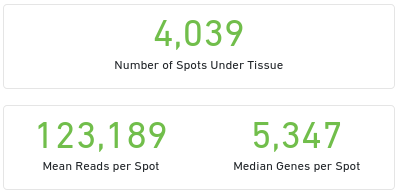


What do you think of the quality of the data?

The image shown in the web report in generated from the input image (`V1_Human_Lymph_Node_image.tif`):

<img src="../../../shared/Spatial_TX/lymph_node/raw/spatial/tissue_lowres_image.png" width="400" height="400">

Here the dotted boundaries are important markes for Space Ranger to detect the correct orientation of the image, but can be ignored for further analysis.
The tissue region inside this boundaries are were sequenced.

<img src="../../../shared/Spatial_TX/lymph_node/raw/spatial/aligned_fiducials.jpg" width="400" height="400">

Furthermore, a folder contains a subfolder `spatial` which contains the locations for each spot on the image and different quality images, which can be used for faster processing.

Remember the lecture, how many cells can be in one spot?

### Reading data

This data can be read into a usable format by using [scanpy](scanpy.readthedocs.io/en/stable/). scanpy is a library for the analysis of single-cell RNAseq and spatial transcriptomics data sets, including 10X Visium. 

In [4]:
import scanpy as sc
sc.settings.verbosity = 3

We'll use the [read_visium](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read_visium.html#scanpy-read-visium) function, 
which automatically reads in all necessary files from our directory.

Take a moment and think about which files this might be.

We'll also read the original image by providing the `source_image_path` argument. 

In [5]:
adata = sc.read_visium(filepath, source_image_path=filepath + "/V1_Human_Lymph_Node_image.tif")
adata

reading /home/shared/Spatial_TX/lymph_node/raw/filtered_feature_bc_matrix.h5
 (0:00:01)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

As you can see, the data was successfully loaded into an [AnnData](https://anndata.readthedocs.io/en/latest/). Before continuing and fixing the "UserWarning", we'll briefly introduce the AnnData format. 

Why do you think there is a warning?

### The AnnData format

A AnnData object is a container storing the expression information `adata.X`, spot metadata `adata.obs`, gene metadata `adata.var` and several other information, e.g. the spatial images in `adata.obsm` and `adata.uns`.

In [6]:
adata.X

<4035x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 23717106 stored elements in Compressed Sparse Row format>

In [7]:
adata.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACAATCTACTAGCA-1,1,3,43
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27
TTGTTTGTATTACACG-1,1,73,41


In [8]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


Since some of the genes symbols (bold names in the table above) appear multiple times (see UserWarning when reading the data), we need to make those unique using [adata.var_names_make_unique()](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.var_names_make_unique.html).

In [9]:
adata.var_names_make_unique()

### Simple visualization

Also the image can be visualized using scanpy's plotting functions. Here big parts of the boundary boxes are automatically cut out.

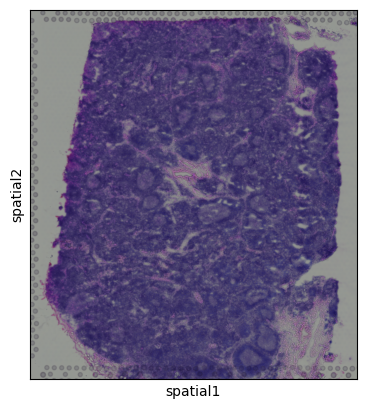

In [10]:
sc.pl.spatial(adata)

The same function can also be used to visualize the gene expression, e.g. for the ribosomal protein _RPS2_.
This gene is expressed in nearly all cells.

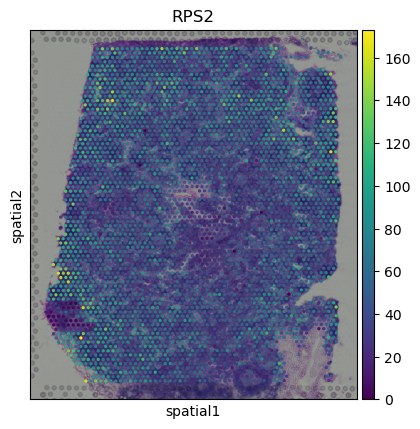

In [11]:
sc.pl.spatial(adata, color="RPS2")

Change the gene name for another gene and examine the distribution

The expression is shown as colored dots in top of the image. Each dot is a spot consisting of one to a few cells.
If a spot contains multiple cells, the expression is averaged across all cells due to limitations in the sequencing protocol.

## Check Quality Control (QC) & Filtering

However, as you can see in the plot above, some spots show very low expression of housekeeping genes, e.g. _RPS2_. This could potentially identify spots, which are of low quality and thus should be removed for further processing.

Thus, in the following we'll perform some basic quality checks and subsequent filtering of low quality spots.

### Quality metrics

We'll consider the following quality metrics:
* the number of genes expressed in the count matrix
* the total counts per spot

These metrics can be calculated using the [sc.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html) function.

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

This will add more information to the gene metadata `adata.var` and the spot metadata `adata.obs`.

In [13]:
adata.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
FAM138A,ENSG00000237613,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,ENSG00000186092,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,63,0.015861,0.015737,98.438662,64.0,4.174387
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,1,0.000248,0.000248,99.975217,1.0,0.693147
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,0,0.000000,0.000000,100.000000,0.0,0.000000
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,120,0.030235,0.029787,97.026022,122.0,4.812184


In [15]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAAGTATCTCCCA-1,1,50,102,6732,8.814776,27944.0,10.237993,33.241483,41.071429,48.375322,57.572287
AAACAATCTACTAGCA-1,1,3,43,6759,8.818778,25685.0,10.153702,23.507884,33.965349,42.631886,53.054312
AAACACCAATAACTGC-1,1,59,19,8590,9.058470,42942.0,10.667629,22.502445,31.770761,40.584975,50.815053
AAACAGAGCGACTCCT-1,1,14,94,7236,8.886962,31916.0,10.370894,21.948239,31.990224,41.101642,52.603710
AAACAGCTTTCAGAAG-1,1,43,9,6890,8.837971,30932.0,10.339579,26.357817,38.132032,47.575327,57.590844
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,5771,8.660774,19649.0,9.885833,27.131152,35.950939,44.429742,55.000254
TTGTTTCATTAGTCTA-1,1,60,30,6354,8.756997,21557.0,9.978502,24.238067,32.263302,40.265343,51.152758
TTGTTTCCATACAACT-1,1,45,27,6517,8.782323,22175.0,10.006766,21.506201,30.593010,39.098083,50.119504
TTGTTTGTATTACACG-1,1,73,41,4476,8.406708,12268.0,9.414831,24.078904,34.268014,43.193675,54.964134


We'll focus on the spot metadata and the variables for the total counts per spot `total_counts` and  the number of genes expressed `n_genes_by_counts`.

### Visual assessment & Filtering

Since the interpretation of these metrics using the tabular format above is very challenging, usually simple visualizations, e.g. histograms are often used. 

Therefore we need plotting functions from [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

Now we'll plot histograms summarizing these metrics across all spots. 
The y-axis shows the number of cells having "x" total number of counts (x-axis) or number of expressed genes. 

Spots with too less or too many expressed genes are usually removed. Theses are representing the tails of the shown distribution.

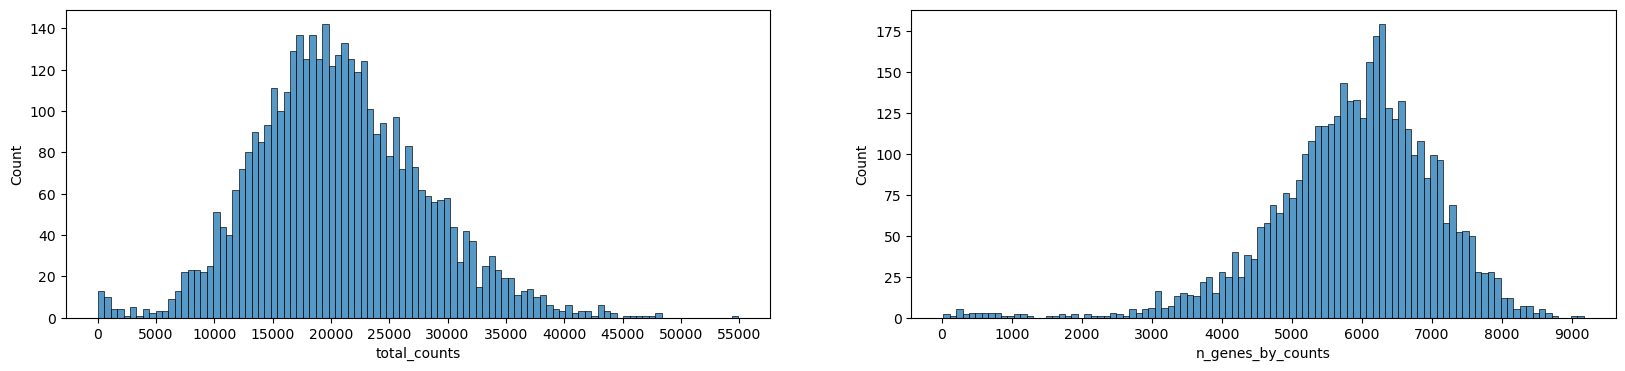

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
bins = np.histogram(adata.obs["total_counts"], bins=100)[1]
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0], bins=bins)
axs[0].xaxis.set_major_locator(plticker.MultipleLocator(base=5000.0))
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=100, ax=axs[1])
axs[1].xaxis.set_major_locator(plticker.MultipleLocator(base=1000.0))

In [17]:
min_counts=5000
max_counts=35000

Let's now filter spots with have at least 5000 counts per spot and a maximum of 35000 counts per spot and see what happens to the plots below. 

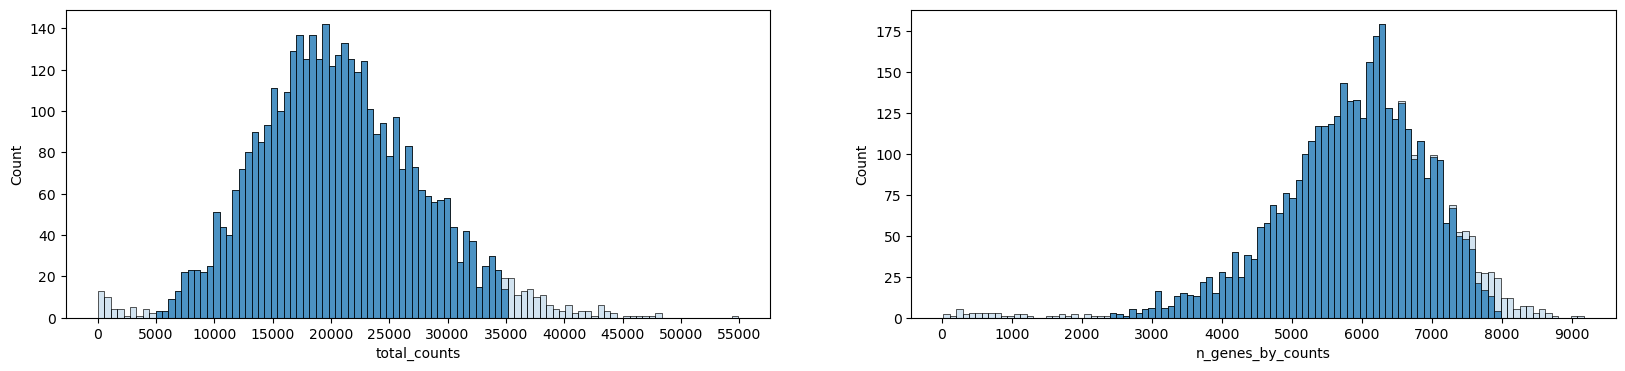

'This settings would remove 174 spots.'

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
tmp = adata.obs.query(f"total_counts > {min_counts} & total_counts < {max_counts}")
bins = np.histogram(adata.obs["total_counts"], bins=100)[1]
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0], bins=bins, alpha=0.2)
sns.histplot(tmp["total_counts"], kde=False, ax=axs[0], bins=bins, color='C0')
axs[0].xaxis.set_major_locator(plticker.MultipleLocator(base=5000.0))
bins = np.histogram(adata.obs["n_genes_by_counts"], bins=100)[1]
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1], bins=bins, alpha=0.2)
sns.histplot(tmp["n_genes_by_counts"], kde=False, ax=axs[1], bins=bins, color='C0')
axs[1].xaxis.set_major_locator(plticker.MultipleLocator(base=1000.0))
plt.show()
display(f"This settings would remove {adata.n_obs-len(tmp)} spots.")

The lighter bars, represent spots which would be removed by our current filter settings.

Does this look good to you know? 
Or should more or less spots be removed? Try a few values and see how the function behaves. 

Are you satisfied?  Then let's apply the final filtering settings using [sc.pp.filter_cells](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_cells.html)

In [19]:
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)

filtered out 44 cells that have less than 5000 counts
filtered out 130 cells that have more than 35000 counts


While we now filtered low quality spots, there are also genes, which are not expressed in most cells.
This genes do not add much information, so we can remove them as well to speed up further computations.


In [20]:
sc.pp.filter_genes(adata, min_cells=10)

filtered out 16916 genes that are detected in less than 10 cells


Let's look now on the data set we have more visually.  Therefore we can use the same plotting function as before for plotting the gene expression _RPS2_, but we can also plot `total_counts` and `n_genes_by_counts` per spot. 

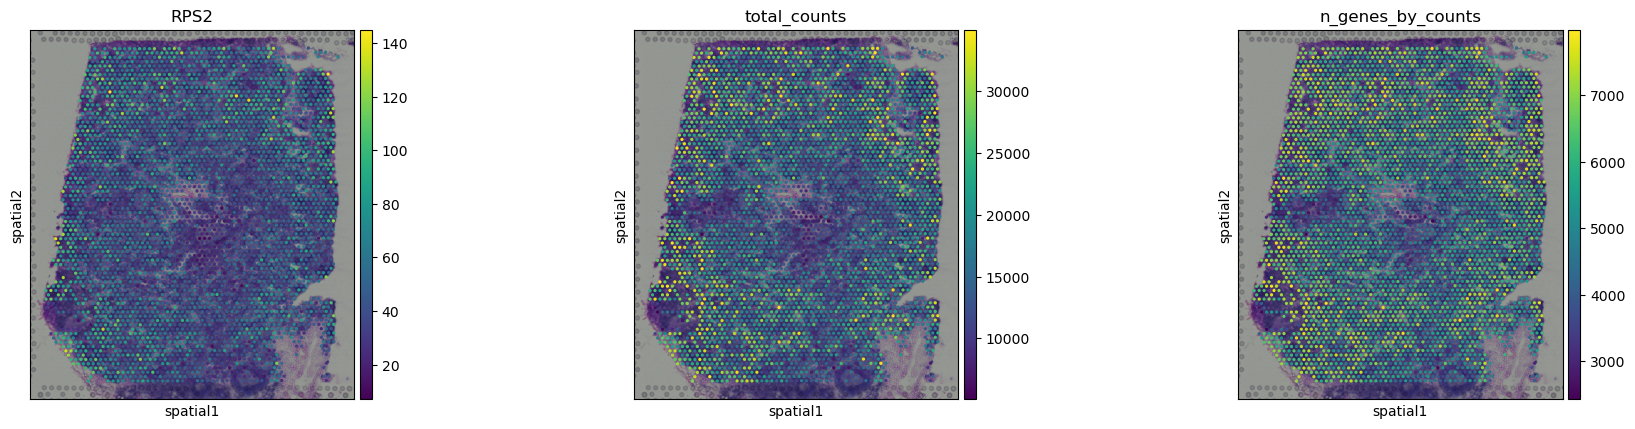

In [21]:
sc.pl.spatial(adata, color=["RPS2","total_counts", "n_genes_by_counts"])

What do you see?  Has the _RPS2_ expression plot changed before and after filering?

## Preprocessing

Now, after filtering we need to perform some preprocessing on the count matrix and dimensionality reduction for visualization of the expression information.

### Normalization

We'll normalize the expression data, such that each spots has a total count of 10,000. This will make spots more comparable between each other. 

In [22]:
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Furthermore, we need to log-transform the data. This will help to a more gaussian-like distribution and is important for the statistical assumptions of downstream methods.

In [23]:
sc.pp.log1p(adata)

We'll set the `.raw` attribute of the AnnData object to the normalized raw gene expression for later use, for example in differential expression testing and visualizations of gene expression.

In [24]:
adata.raw = adata.copy()

### Dimensionality reduction

Since this high-dimensional expression matrix is very hard to visualize, dimensionality reduction is performed. 

This is also a very computationally expensive step, and thus the selection of highly variable genes is done prior to dimensionality reduction.
Highly variable gene selection can be done with the [sc.pp.highly_variable_genes](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html). We'll use a method which is commonly used by the popular R package Seurat.


In [25]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Based on highly variable genes, then the first step of dimensionality reduction is performed. 
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) tries to find a representation of the count data which is of lower dimensionality but maximing the preserved variance in the data.

In [26]:
sc.pp.pca(adata, use_highly_variable=True, n_comps=100)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:02)


Because we want to keep as much information as possible while still discarding noise, we select 50 principal components for visualization using [UMAP](https://umap-learn.readthedocs.io/en/latest/).
This is 2-dimensional representation, which tries to preserve the similarities between spots. 

The computation involves two steps:
1. Compute spot similar spots (neigbors)
2. Computing the representation

In [28]:
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


This representation can than be displayed using [sc.pl.umap](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.umap.html)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


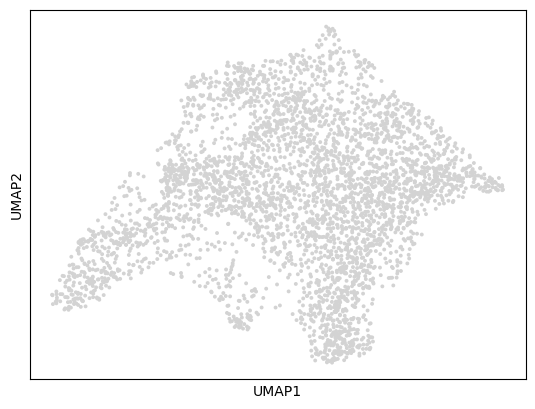

In [29]:
sc.pl.umap(adata)

Does this look good ?  How does it changes, if you're using a different number of principal components (`n_pcs=`)?


Can you color the above UMAP using _IL7R_ gene expression, `total_counts`? 
What do you see? 

### Saving

Great, we performed:
* Data reading
* Quality control
* Filtering
* Preprocessing

Let's now save the data ... 

In [30]:
adata.write("lymph_node_raw.h5ad")

... and continue with [Session 3 - Clustering and Annotation](./Session_3_Clustering_and_Annotation.ipynb)